In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np

import os
import glob
import re
import torch
from preprocessor import get_dataset

In [3]:
best_overall_params = {}

['../results/grid_results_8_1e-05.pt', '../results/grid_results_8_5e-05.pt', '../results/grid_results_8_0.0001.pt', '../results/grid_results_4_1e-05.pt', '../results/grid_results_4_0.0001.pt', '../results/grid_results_2_0.0001.pt', '../results/grid_results_4_5e-05.pt', '../results/grid_results_2_1e-05.pt', '../results/grid_results_2_5e-05.pt']


/tmp/ipykernel_2702334/3049341635.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  result = torch.load(file_path, map_location=torch.device('cpu'))



Best validation loss: 0.6611025961240132
Best file: (8, 0.0001)


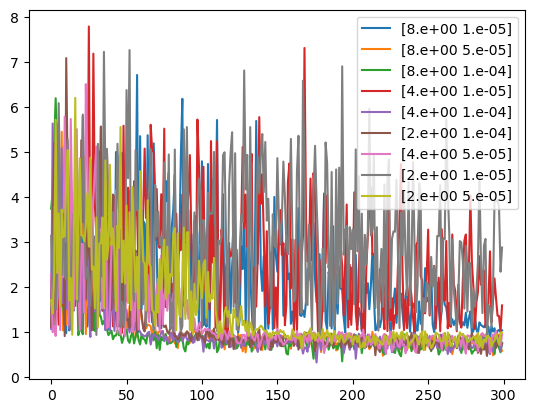

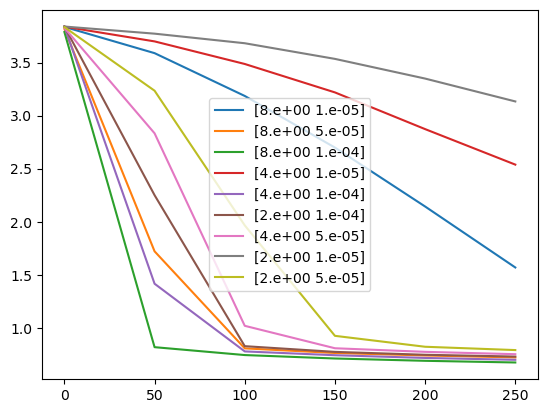

In [4]:
best_val_loss = 1000
best_params = None

all_train_loss = []
all_val_loss = []
all_keys = []

best_val_loss = 1000
best_lora_lr = None

# Find all grid_results joblib files in the results folder
pattern = r'grid_results_\d+_[\d.e+-]+\.pt'

# Get all files in the results directory
result_files = glob.glob('../results/*')

# Filter files that match the pattern
result_files = [file for file in result_files if re.search(pattern, file)]
print(result_files)

# Display the content of each file
for file_path in result_files:
    # Load the joblib file
    result = torch.load(file_path, map_location=torch.device('cpu'))
    
    key = next(iter(result.keys()))
    # print(f"Key: {key}: ", result[key]['final_val_loss'])

    all_train_loss.append(result[key]['train_losses'])
    all_val_loss.append(result[key]['val_losses'])
    all_keys.append(key)
    
    # Check if the current file has the best validation loss
    if result[key]['final_val_loss'] < best_val_loss:
        best_val_loss = result[key]['final_val_loss']
        best_lora_lr = key

print(f"\n{'='*50}")
print(f"Best validation loss: {best_val_loss}")
print(f"Best file: {best_lora_lr}")
print(f"{'='*50}")

best_overall_params['lora_rank'] = best_lora_lr[0]
best_overall_params['learning_rate'] = best_lora_lr[1]

all_train_loss = np.array(all_train_loss)
all_val_loss = np.array(all_val_loss)
all_keys = np.array(all_keys)

fig, ax = plt.subplots()
for i in range(len(all_train_loss)):
    ax.plot(all_train_loss[i, :, 1], all_train_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

fig, ax = plt.subplots()
for i in range(len(all_val_loss)):
    ax.plot(all_val_loss[i, :, 1], all_val_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

/tmp/ipykernel_2702334/4113119274.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  result = torch.load(file_path, map_location=torch.device('cpu'))


Key: 768:  0.6614443337917328
Key: 128:  0.8950828814506531
Key: 512:  0.6642499995231629

Best validation loss: 0.6614443337917328
Best file: 768


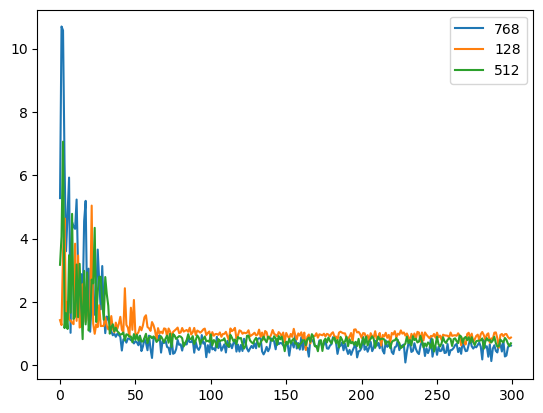

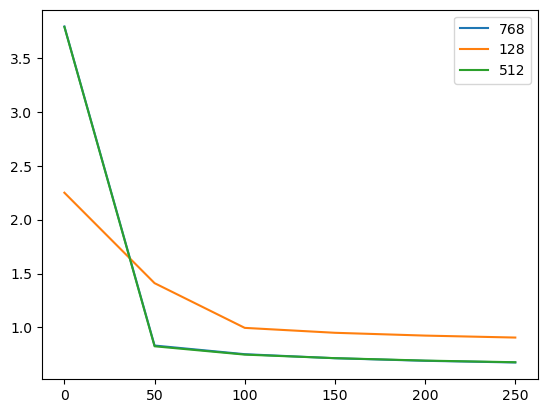

In [5]:
best_val_loss = 1000
best_params = None

all_train_loss = []
all_val_loss = []
all_keys = []

best_val_loss = 1000
best_ctx = None

# Pattern to match files of the form grid_results_NUMBER.joblib
pattern = r'grid_results_\d+\.pt'

# Get all files in the results directory
result_files = glob.glob('../results/*')

# Filter files that match the pattern (just one number after grid_results_)
result_files = [file for file in result_files if re.search(pattern, file)]

# print(result_files)

# Display the content of each file
for file_path in result_files:
    # Load the joblib file
    result = torch.load(file_path, map_location=torch.device('cpu'))
    
    key = next(iter(result.keys()))
    print(f"Key: {key}: ", result[key]['final_val_loss'])

    all_train_loss.append(result[key]['train_losses'])
    all_val_loss.append(result[key]['val_losses'])
    all_keys.append(key)
    
    # Check if the current file has the best validation loss
    if result[key]['final_val_loss'] < best_val_loss:
        best_val_loss = result[key]['final_val_loss']
        best_ctx = key

print(f"\n{'='*50}")
print(f"Best validation loss: {best_val_loss}")
print(f"Best file: {best_ctx}")
print(f"{'='*50}")

best_overall_params['max_ctx_length'] = best_ctx

all_train_loss = np.array(all_train_loss)
all_val_loss = np.array(all_val_loss)

fig, ax = plt.subplots()
for i in range(len(all_train_loss)):
    ax.plot(all_train_loss[i, :, 1], all_train_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

fig, ax = plt.subplots()
for i in range(len(all_val_loss)):
    ax.plot(all_val_loss[i, :, 1], all_val_loss[i, :, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

In [46]:
result = torch.load(f"../results/lora_run_CSD3_4k_default.pt", map_location=torch.device('cpu'))
for key in result.keys():
    print(f"Key: {key}: ")

Key: train_losses: 
Key: val_losses: 
Key: grad_track: 
Key: prediction_decoded: 
Key: test_decoded: 
Key: metrics: 


/tmp/ipykernel_2702334/711587923.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  result = torch.load(f"../results/lora_run_CSD3_4k_default.pt", map_location=torch.device

/tmp/ipykernel_2702334/1123255769.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  result = torch.load(file_path, map_location=torch.device('cpu'))


(300, 24, 2, 2)


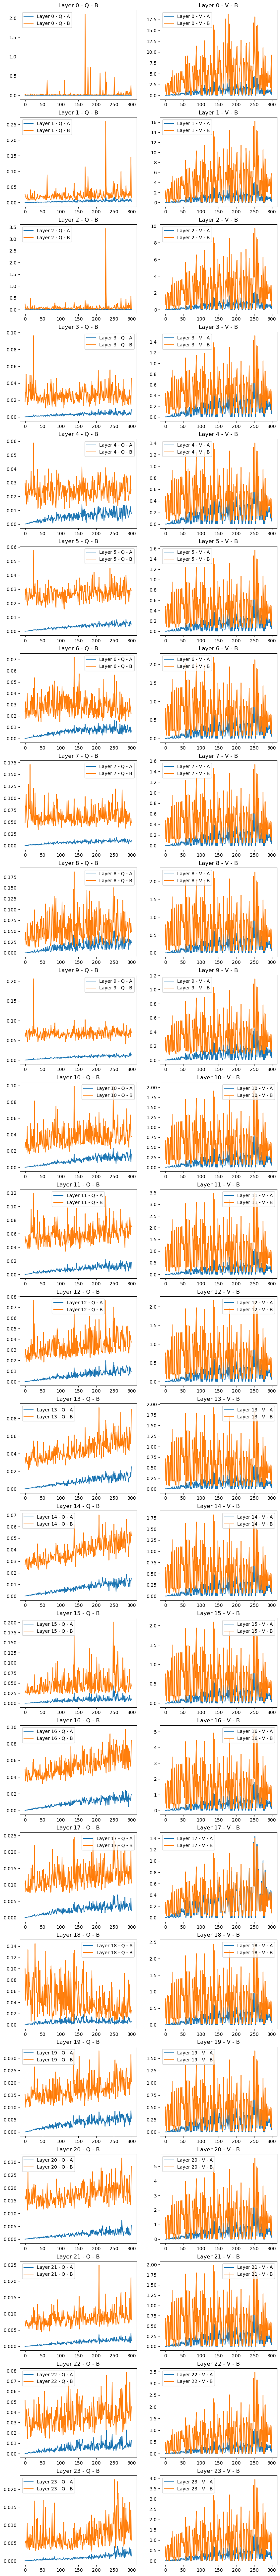

In [42]:
pattern = r'grid_results_*'

# Get all files in the results directory
result_files = glob.glob('../results/*')

# Filter files that match the pattern (just one number after grid_results_)
result_files = [file for file in result_files if re.search(pattern, file) and not re.search(r'alpha', file)]

for file_path in result_files:
    # Load the joblib file
    result = torch.load(file_path, map_location=torch.device('cpu'))
    
    key = next(iter(result.keys()))
    grad = result[key]['grad_track']
    step = []
    gradients = np.zeros((len(grad), 24, 2, 2))
    print(gradients.shape)
    for g in grad:
        for i in range(24):
            for proj in ("q_proj", "v_proj"):
                for matrix in ("A", "B"):
                    name = "{}.{}.{}".format(i, proj, matrix)
                    gradients[g['step']][i][0 if proj == "q_proj" else 1][0 if matrix == "A" else 1] = g['gradients'][name]

    fig, ax = plt.subplots(24, 2, figsize=(10, 100))
    for i in range(24):
        for j in range(2):
            for k in range(2):
                ax[i][j].plot([g[i][j][k] for g in gradients], label=f"Layer {i} - {'Q' if j == 0 else 'V'} - {'A' if k == 0 else 'B'}")
                ax[i][j].set_title(f"Layer {i} - {'Q' if j == 0 else 'V'} - {'A' if k == 0 else 'B'}")
                ax[i][j].legend()
    plt.show
    break

['../results/lora_run_CSD3_4k_default.pt', '../results/lora_run_CSD3_15k_seed_defaults.pt', '../results/lora_run_CSD3_default.pt']


/tmp/ipykernel_2702334/2199726927.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  result = torch.load(file_path, map_location=torch.device('cpu'))


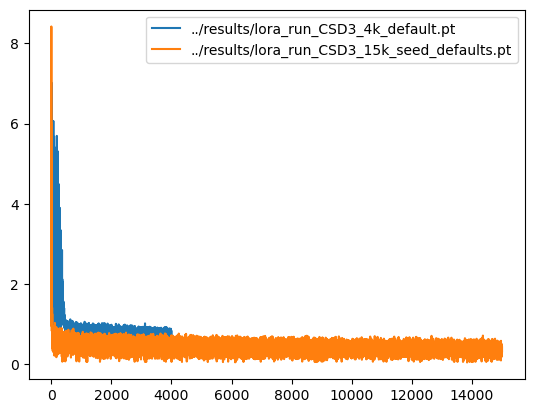

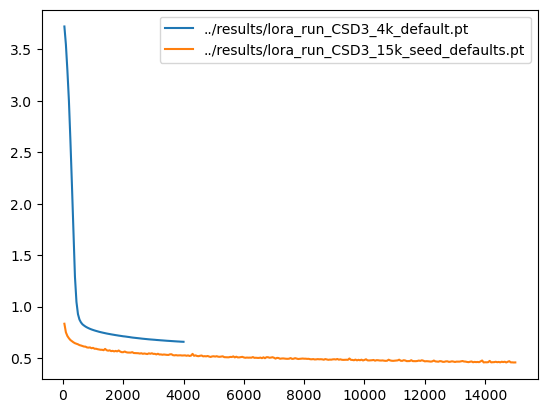

mean_prey_squared_error 0.14639556000000004 0.0043201099999999985 True
mean_prey_absolute_error 0.14088 0.020949999999999993 True
r2_prey_score 0.6570634222698106 0.9860259814362329 False
mean_predator_squared_error 0.06596183 0.004949109999999998 True
mean_predator_absolute_error 0.09454999999999998 0.025249999999999995 True
r2_predator_score 0.6277967014994824 0.9644386504548648 False
running_mse_prey [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.67901234567903e-06, 8.186585365853652e-05, 0.00019424096385542208, 0.000445690476190477, 0.0011816352941176485, 0.0027770116279069793, 0.004821241379310346, 0.006658090909090909, 0.008991921

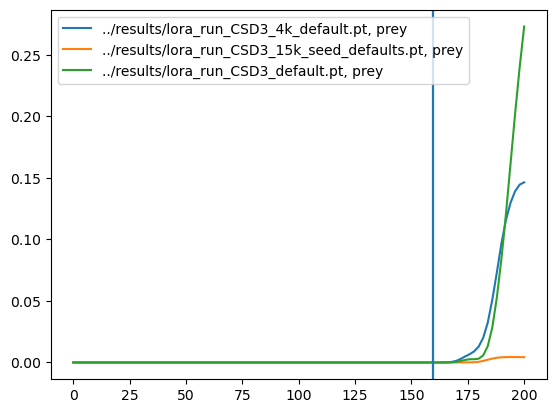

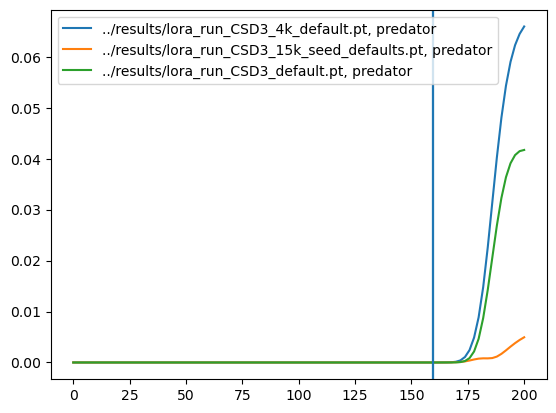

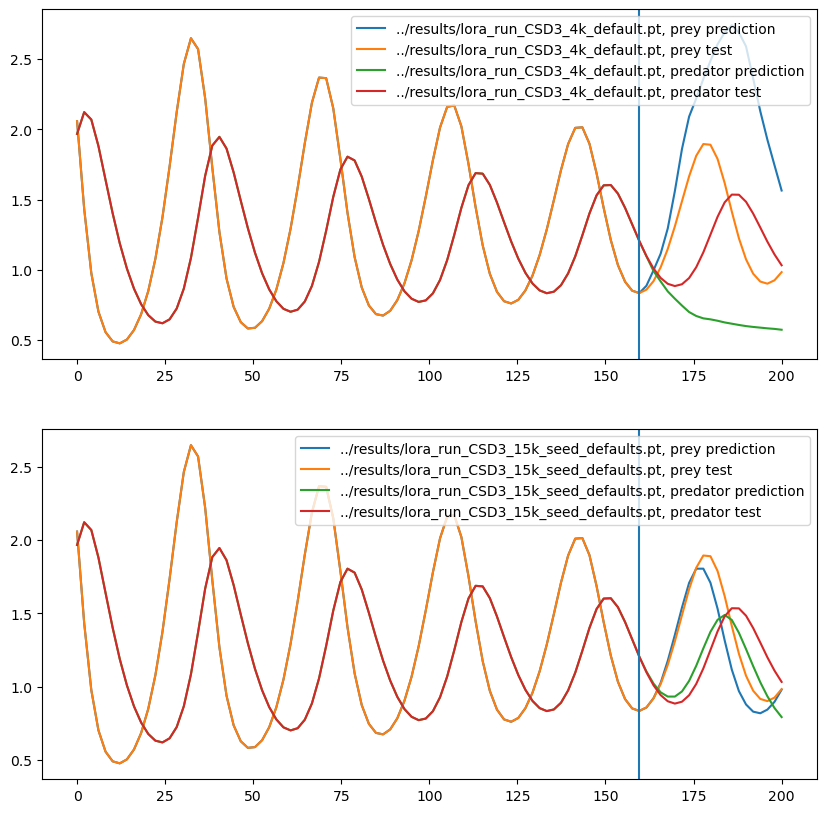

In [7]:
all_train_loss = []
all_val_loss = []
all_keys = []
all_predictions = []
all_tests = []
all_metrics = []

# Pattern to match files of the form grid_results_NUMBER.joblib
pattern = r'lora_run_CSD3_(.*default\.pt|.*seed_defaults\.pt)'

# Get all files in the results directory
result_files = glob.glob('../results/*')
# print(result_files)

# Filter files that match the pattern (just one number after grid_results_)
result_files = [file for file in result_files if re.search(pattern, file)]

print(result_files)

for file_path in result_files:
    # Load the joblib file

    result = torch.load(file_path, map_location=torch.device('cpu'))

    all_train_loss.append(result['train_losses'])
    all_val_loss.append(result['val_losses'])
    all_keys.append(file_path)
    all_predictions.append(result['prediction_decoded'])
    all_tests.append(result['test_decoded'])
    all_metrics.append(result['metrics'])

fig, ax = plt.subplots()
for i in range(len(all_train_loss)-1):
    ax.plot(all_train_loss[i][:, 1], all_train_loss[i][:, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

fig, ax = plt.subplots()
for i in range(len(all_val_loss)-1):
    ax.plot(all_val_loss[i][:, 1], all_val_loss[i][:, 0], label=f"{all_keys[i]}")
plt.legend()
plt.show()

for metric in all_metrics[0]:
    print(metric, all_metrics[0][metric], all_metrics[1][metric], all_metrics[0][metric] > all_metrics[1][metric])

_, _, times = get_dataset()

fig, ax = plt.subplots()
for i in range(len(all_metrics)):
    ax.plot(times, all_metrics[i]['running_mse_prey'], label=f"{all_keys[i]}, prey")
    ax.axvline(times[79])
plt.legend()
plt.show()

fig, ax = plt.subplots()
for i in range(len(all_metrics)):
    ax.plot(times, all_metrics[i]['running_mse_predator'], label=f"{all_keys[i]}, predator")
    ax.axvline(times[79])
plt.legend()
plt.show()

fig, ax = plt.subplots(2, figsize=(10, 10))
for prediction, test, key, i in zip(all_predictions, all_tests, all_keys, range(2)):
    # print(prediction[0])
    ax[i].plot(times, prediction[0], label=f"{key}, prey prediction")
    ax[i].plot(times, test[0], label=f"{key}, prey test")
    ax[i].plot(times, prediction[1], label=f"{key}, predator prediction")
    ax[i].plot(times, test[1], label=f"{key}, predator test")
    ax[i].axvline(times[79])
    ax[i].legend()
# plt.legend()
plt.show()
